In [1]:
import numpy as np
import gymnasium as gym
import pen_world
from PPO import PPO

### Initialize Environment and Agent

In [2]:
initialization_radius = 10  # radius of initialization positions (all agent initializations are done n steps from env center)
env = gym.make('PenWorld-v0', n=initialization_radius)
state_dim = 2  # state is given by 2D x,y coordinates
action_dim = 27  # total action space of all positions
lr_actor = 0.0001  # learning rate for actor
lr_critic = 0.0003  # learning rate for critic
gamma = 0.99  # discount factor
K_epochs = 8  # update policy for K epochs
eps_clip = 0.2  # clip parameter for PPO
has_continuous_action_space = False  # discrete action space
update_timestep = env.max_ep_length * 4  # update policy every n timesteps
max_ep_length = env.max_ep_length  # max timesteps in one episode
variable_action_space = True  # variable action space (action space is different for each state)
device = 'cpu'  # can be set to 'cpu' or 'cuda'

# initialize a PPO agent
ppo_agent = PPO(state_dim, action_dim, lr_actor, lr_critic, gamma, K_epochs, eps_clip, has_continuous_action_space, device=device, variable_action_space=variable_action_space)

number of nodes in sub environment: 256
max_ep_length: 512


### Train Agent
Agent trained for 5000 episodes so that it can learn to reliably find the reward

In [3]:
import time
debug=False
time_step = 0
i_episode = 0
# training loop
reward_times = []
num_episodes = 10000
average_rewards = []
t0 = time.time()
log_running_reward = 0
log_running_episodes = 0

for episode in range(num_episodes):

    observation, info = env.reset()
    current_ep_reward = 0
    if i_episode % 100 == 0:
        print(f"episode: {i_episode}")
        print(f"Time per 100 episodes: {time.time() - t0} s")
        t0 = time.time()

        if i_episode > 0:
            average_reward = log_running_reward / log_running_episodes
            log_running_episodes = 0
            log_running_reward = 0
            print(f"average reward: {average_reward}")
            average_rewards.append(average_reward)

    for t in range(1, max_ep_length + 1):

        # select action with policy
        action_mask = info['action_mask']
        action = ppo_agent.select_action(observation, action_mask, debug)
        observation, reward, terminated, truncated, info = env.step(action)
        done = terminated or truncated

        # saving reward and is_terminals
        ppo_agent.buffer.rewards.append(reward)
        ppo_agent.buffer.is_terminals.append(done)

        time_step += 1
        current_ep_reward += reward
        
        # save time till reward
        if reward > 0:
            reward_times.append(env.t)
            log_running_reward += 1

        # update weights of agent
        if time_step % update_timestep == 0:
            ppo_agent.update()

        # break; if the episode is over
        if done:
            break

    i_episode += 1
    log_running_episodes += 1

episode: 0
took 0.0008790493011474609 s
episode: 100
took 9.389660120010376 s
average reward: 0.65
episode: 200
took 5.688010931015015 s
average reward: 0.83
episode: 300
took 5.81580114364624 s
average reward: 0.82
episode: 400
took 4.447878122329712 s
average reward: 0.91
episode: 500
took 4.514321804046631 s
average reward: 0.87
episode: 600
took 3.6592791080474854 s
average reward: 0.95
episode: 700
took 2.1819028854370117 s
average reward: 0.99
episode: 800
took 3.2711286544799805 s
average reward: 0.95
episode: 900
took 2.6075358390808105 s
average reward: 0.97
episode: 1000
took 2.9943387508392334 s
average reward: 0.98
episode: 1100
took 1.8115880489349365 s
average reward: 1.0
episode: 1200
took 1.8829848766326904 s
average reward: 0.98
episode: 1300
took 1.2746479511260986 s
average reward: 1.0
episode: 1400
took 1.3750219345092773 s
average reward: 1.0
episode: 1500
took 1.629776954650879 s
average reward: 0.99
episode: 1600
took 1.231034278869629 s
average reward: 0.98
epis

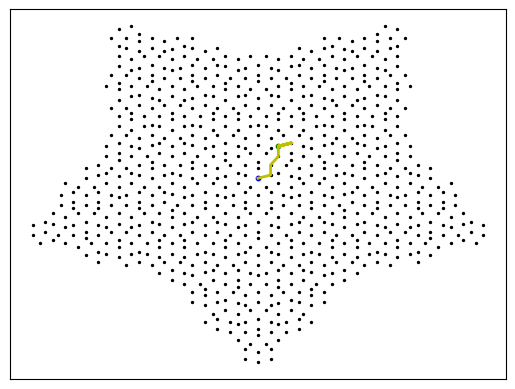

In [4]:
import matplotlib.pyplot as plt

observation, info = env.reset()
start_position = env.coordinates
trajectory = [np.array(start_position)]
for t in range(1, max_ep_length+1):
    # print(f"t: {t}")
    # select action with policy
    action_mask = env.get_action_mask()
    action = ppo_agent.select_action(observation, action_mask)
    observation, reward, terminated, truncated, info = env.step(action)

    # saving reward and is_terminals
    ppo_agent.buffer.rewards.append(reward)
    ppo_agent.buffer.is_terminals.append(done)
    trajectory.append(env.coordinates)

    time_step +=1
    current_ep_reward += reward
    # elif done:
    #     # print("done but no reward")
    # update PPO agent
    if reward == 1:
        break

small_s = 2
big_s = 10
plt_size = 50

trajectory = np.array(trajectory)
reward_position = (0, 0)
positions = np.array(list(env.graph.keys()))
plt.scatter(positions[:, 0], positions[:, 1], s=small_s, c='k')
plt.plot(trajectory[:, 0], trajectory[:, 1], c='y', linewidth=small_s)
plt.scatter(start_position[0], start_position[1], s=big_s, c='g')
plt.scatter(reward_position[0], reward_position[1], s=big_s, c='b')
plt.xticks([])
plt.yticks([])
plt.show()

### Save Agent

In [12]:
ppo_agent.save('pen_world_agent.pth')
ppo_agent = PPO.load('pen_world_agent.pth')